# Grupowanie - single users + anxiety + depression

# Wczytanie danych:

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics, datasets
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc

#Zbiór danych users
users = pd.read_csv('ausers.csv', delimiter=';')
#print(users.head(50))

In [3]:
anxiety = pd.read_csv('aanxiety.csv', delimiter=';')
print(anxiety.head(5))

duplicates = anxiety.duplicated().sum()
#print(f"Duplikaty: {duplicates}")

            attributes              date email gender
0  3|3|2|3|3|2|0|2|3|0  2021-11-13 14:52  ID13      M
1  2|2|2|1|2|2|0|1|1|1  2021-11-13 14:52  ID48      M
2  3|3|1|2|2|2|2|1|1|1  2021-11-13 15:03   ID6      M
3  2|2|2|2|2|2|1|2|2|2  2021-11-13 15:04   ID5      K
4  1|1|1|1|1|1|0|1|1|2  2021-11-13 15:04  ID34      M


In [4]:
depression = pd.read_csv('adepression.csv', delimiter=';')
print(anxiety.head(5))

duplicates = depression.duplicated().sum()
#print(f"Duplikaty: {duplicates}")

            attributes              date email gender
0  3|3|2|3|3|2|0|2|3|0  2021-11-13 14:52  ID13      M
1  2|2|2|1|2|2|0|1|1|1  2021-11-13 14:52  ID48      M
2  3|3|1|2|2|2|2|1|1|1  2021-11-13 15:03   ID6      M
3  2|2|2|2|2|2|1|2|2|2  2021-11-13 15:04   ID5      K
4  1|1|1|1|1|1|0|1|1|2  2021-11-13 15:04  ID34      M


# Usuwanie wierszy:

Do usuwania numery wierszy -2 w stosunku do csv
Powtarzające się ID w aanixiety: 
- ID83 - ponad rok różnicy, zostawione oba
- ID76 - -//-
- ID86 - mniej niż godzina różnicy, wywalić wiersz nr 41 (albo 40 bez nagłówka)
- ID82 - ponad rok różnicy, zostawione oba
- ID215 - ponad dzień różnicy, zostawione oba
- ID162 - mniej niż godzina różnicy, wywalić wiersz nr 70 (albo 69 bez nagłówka)
- ID212 - parę godzin ponad dzień różnicy, więc zostawione oba???
- ID174 - wywalić wiersz nr 93 (92 bez nagłówka)
- ID214 - 22h różnicy??? - zatwierdzone - oba zostawić!!!
- ID129 - kilka dni różnicy, zostawione oba

W adepression: 
Pierwsze dwa tak samo.
ID86 nie istnieje???
- ID82 - mniej niż godzina różnicy, wywalić wiersz nr 36 (albo 35 bez nagłówka)
- ID212 - parę godzin ponad dzień różnicy, więc zostawione oba???
- ID174 - wywalić wiersz 70

In [5]:
do_usuniecia_anxiety = [39, 68, 91]
do_usuniecia_depression = [34, 68]

anxiety = anxiety.drop(anxiety.index[do_usuniecia_anxiety])
anxiety = anxiety.reset_index(drop=True)

depression = depression.drop(depression.index[do_usuniecia_depression])
depression = depression.reset_index(drop=True)

# Przygotowanie danych: 

In [6]:
# Przygotowanie atrybutów anxiety:
anxiety_split = anxiety['attributes'].str.split('|', expand=True)
anxiety_split.columns = [f'f_{i}' for i in range(anxiety_split.shape[1])]
anxiety = pd.concat([anxiety_split, anxiety['date'], anxiety['email'], anxiety['gender']], axis=1)
print(anxiety.head(5))

  f_0 f_1 f_2 f_3 f_4 f_5 f_6 f_7 f_8 f_9              date email gender
0   3   3   2   3   3   2   0   2   3   0  2021-11-13 14:52  ID13      M
1   2   2   2   1   2   2   0   1   1   1  2021-11-13 14:52  ID48      M
2   3   3   1   2   2   2   2   1   1   1  2021-11-13 15:03   ID6      M
3   2   2   2   2   2   2   1   2   2   2  2021-11-13 15:04   ID5      K
4   1   1   1   1   1   1   0   1   1   2  2021-11-13 15:04  ID34      M


In [7]:
# Przygotowanie atrybutów depression:
d_split = depression['attributes'].str.split('|', expand=True)
d_split.columns = [f'f_{i}' for i in range(d_split.shape[1])]
depression = pd.concat([d_split, depression['date'], depression['email'], depression['gender']], axis=1)
print(depression.head(5))

  f_0 f_1 f_2 f_3 f_4 f_5 f_6 f_7 f_8 f_9              date email gender
0   1   1   0   3   2   1   2   0   2   1  2021-11-13 14:52  ID13      M
1   1   1   1   1   1   0   1   1   0   1  2021-11-13 14:52  ID48      M
2   1   1   0   1   1   1   1   1   1   1  2021-11-13 15:03   ID6      M
3   1   1   1   1   0   1   1   1   1   1  2021-11-13 15:04  ID34      M
4   2   0   0   1   2   2   1   1   2   2  2021-11-13 15:04   ID5      K


In [8]:
featuresA = anxiety.iloc[:,0:10] #cechy do grupowania
featuresA = featuresA.rename(columns=lambda x: f"{x}_a") #Zmiana nazwy, żeby można było rozróżnić cechy
featuresD = depression.iloc[:,0:10] 
featuresD = featuresD.rename(columns=lambda x: f"{x}_d")

all_features = pd.concat([featuresA, featuresD], axis=1)
indexes = []

for i in range(len(all_features)):
    if all_features.iloc[i].isna().any():
        indexes.append(i)
        
all_features = all_features.drop(all_features.index[indexes])    
all_features = all_features.reset_index(drop=True)
print(all_features)

   f_0_a f_1_a f_2_a f_3_a f_4_a f_5_a f_6_a f_7_a f_8_a f_9_a f_0_d f_1_d  \
0      3     3     2     3     3     2     0     2     3     0     1     1   
1      2     2     2     1     2     2     0     1     1     1     1     1   
2      3     3     1     2     2     2     2     1     1     1     1     1   
3      2     2     2     2     2     2     1     2     2     2     1     1   
4      1     1     1     1     1     1     0     1     1     2     2     0   
..   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
88     1     1     1     1     1     1     0     0     1     1     1     1   
89     1     1     2     1     0     0     0     0     2     1     2     2   
90     2     1     2     1     1     1     1     1     2     2     1     2   
91     2     2     2     2     1     1     1     1     0     1     0     0   
92     3     1     2     1     1     1     1     2     1     2     2     2   

   f_2_d f_3_d f_4_d f_5_d f_6_d f_7_d f_8_d f_9_d  
0      0  

In [9]:
print(users)

     birth_year  child_number doughter_birth_years education  email gender  \
0          1981             3            2009,2015    wyższe    ID1      M   
1          1984             3            2009,2015    wyższe    ID2      K   
2          1991             0                  NaN    wyższe    ID3      K   
3          1988             0                  NaN    wyższe    ID4      M   
4          1984             0                  NaN    wyższe    ID5      K   
..          ...           ...                  ...       ...    ...    ...   
279        1974             6       1999,2000,2007    wyższe  ID280      M   
280        1990             0                  NaN    wyższe  ID281      K   
281        1989             0                  NaN   średnie  ID282      M   
282        1985             2            2019,2021    wyższe  ID283      K   
283        1986             2            2019,2021   średnie  ID284      M   

     mariage_year partner_email  relation_start_year son_birth_

Birth year - zamienić na wiek i uwzględnić wiek najmłodszego dziecka, średnia wieku i ile jest synów i córek

In [10]:
from pandas.api.types import CategoricalDtype
from datetime import datetime
current_year = datetime.now().year #Bieżący rok

single_ad = users.copy()

#Eliminowanie NaN
for i in range(len(single_ad)):
    if pd.isna(single_ad['doughter_birth_years'].iloc[i]): 
        single_ad.loc[i, 'doughter_birth_years'] = "0"
    if pd.isna(single_ad['son_birth_years'].iloc[i]):
        single_ad.loc[i, 'son_birth_years'] = "0"

#Ilość synów i córek
single_ad['no_of_daughters'] = single_ad['doughter_birth_years'].apply(
    lambda x: 0 if x == '0' else len(x.split(','))
)
single_ad['no_of_sons'] = single_ad['son_birth_years'].apply(
    lambda x: 0 if x == '0' else len(x.split(','))
)
#Wiek najmłodszego dziecka
single_ad['child_birth_years'] = single_ad['doughter_birth_years'].fillna('') + ',' + single_ad['son_birth_years'].fillna('')
single_ad['child_birth_years'] = single_ad['child_birth_years'].str.strip(',')
single_ad['age_oldest_child'] = current_year - single_ad['child_birth_years'].apply(lambda x: max(map(int, x.split(','))))
single_ad['age_oldest_child'] = single_ad['age_oldest_child'].apply(
    lambda x: 0 if x == current_year else x
)
#Średnia wieku dzieci
def calculate_average_years(date_string):
    years = date_string.split(',')  # Daty rozdzielone przecinkami
    age_differences = [current_year - int(year.strip()) for year in years if year.strip().isdigit() and year != '0']
    return round(sum(age_differences) / len(age_differences)) if age_differences else 0

single_ad['average_child_age'] = single_ad['child_birth_years'].apply(calculate_average_years).apply(
    lambda x: 0 if x == current_year else x
)

#Edukacja
education_order = CategoricalDtype(categories=['średnie', 'wyższe'], ordered=True) #0 - średnie, 1 - wyższe
single_ad['education'] = single_ad['education'].astype(education_order)
single_ad['education'] = single_ad['education'].cat.codes

# Mapowanie płci na liczby
gender_mapping = {'K': 0, 'M': 1}
single_ad['gender'] = single_ad['gender'].map(gender_mapping)

# Kolumna rok urodzenia - zamiana na wiek
single_ad['age'] = current_year - single_ad['birth_year'] #Tworzenie nowej kolumny z wiekiem
single_ad['years_of_mariage'] = current_year - single_ad['mariage_year'] #Kolumna ze stażem małżeństwa
single_ad['years_of_relationship'] = current_year - single_ad['relation_start_year'] #Kolumna ze stażem związku

#Usuwanie niepotrzebnych do grupowania kolumn
single_ad = single_ad.drop(columns=['birth_year','email','partner_email','doughter_birth_years','son_birth_years','child_birth_years','mariage_year','relation_start_year'])

print(single_ad)

     child_number  education  gender  no_of_daughters  no_of_sons  \
0               3          1       1                2           1   
1               3          1       0                2           1   
2               0          1       0                0           0   
3               0          1       1                0           0   
4               0          1       0                0           0   
..            ...        ...     ...              ...         ...   
279             6          1       1                3           3   
280             0          1       0                0           0   
281             0          0       1                0           0   
282             2          1       0                2           0   
283             2          0       1                2           0   

     age_oldest_child  average_child_age  age  years_of_mariage  \
0                  10                 13   44                17   
1                  10                

In [11]:
single_ad = pd.concat([all_features, single_ad], axis = 1) #data frame z danymi dot. anxiety i depression dla pojedynczych użytkowników
#print(single_ad)

indexes = []
    
for i in range(len(single_ad)):    
    if single_ad.iloc[i].isna().any():
        indexes.append(i)
        
single_ad = single_ad.drop(single_ad.index[indexes])    
single_ad = single_ad.reset_index(drop=True)
print(single_ad)

   f_0_a f_1_a f_2_a f_3_a f_4_a f_5_a f_6_a f_7_a f_8_a f_9_a  ...  \
0      3     3     2     3     3     2     0     2     3     0  ...   
1      2     2     2     1     2     2     0     1     1     1  ...   
2      3     3     1     2     2     2     2     1     1     1  ...   
3      2     2     2     2     2     2     1     2     2     2  ...   
4      1     1     1     1     1     1     0     1     1     2  ...   
..   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
88     1     1     1     1     1     1     0     0     1     1  ...   
89     1     1     2     1     0     0     0     0     2     1  ...   
90     2     1     2     1     1     1     1     1     2     2  ...   
91     2     2     2     2     1     1     1     1     0     1  ...   
92     3     1     2     1     1     1     1     2     1     2  ...   

   child_number education gender no_of_daughters no_of_sons age_oldest_child  \
0             3         1      1               2          1        

# Grupowanie KMeans

In [12]:
kmeans = KMeans(n_clusters=2, #Liczba skupień
                init='k-means++',
                n_init=10,
                max_iter=300, #Maksymalna liczba iteracji algorytmu
                random_state=0, #Ustawienie ziarna generatora liczb pseudo-losowych                
               )

kmeans.fit(single_ad) #Grupowanie

inertia = kmeans.inertia_
print("Miara jakości = ", inertia);

centroids = kmeans.cluster_centers_
print("Centroidy: \n", centroids)

clusters = kmeans.fit_predict(single_ad)

Miara jakości =  16713.707479508197
Centroidy: 
 [[ 1.81967213  1.14754098  1.37704918  1.3442623   1.06557377  1.01639344
   0.3442623   1.32786885  1.19672131  1.13114754  0.7704918   0.7704918
   0.73770492  1.55737705  1.13114754  0.72131148  0.98360656  0.73770492
   1.08196721  1.06557377  2.1147541   0.78688525  0.49180328  1.06557377
   1.04918033  7.47540984  9.40983607 41.13114754 13.42622951 15.72131148]
 [ 1.6875      1.15625     1.5         1.1875      0.96875     1.03125
   0.46875     1.25        1.1875      1.125       0.65625     0.90625
   0.78125     1.4375      1.0625      0.84375     1.125       0.71875
   0.96875     0.78125     3.4375      0.6875      0.5         1.5625
   1.875      17.9375     23.9375     54.4375     29.75       32.625     ]]


In [13]:
#Dla 3 klastrów
kmeans3 = KMeans(n_clusters=3, #Liczba skupień
                init='k-means++',
                n_init=10,
                max_iter=300, #Maksymalna liczba iteracji algorytmu
                random_state=0, #Ustawienie ziarna generatora liczb pseudo-losowych                
               )

kmeans3.fit(single_ad) #Grupowanie

inertia3 = kmeans3.inertia_
print("Miara jakości = ", inertia3);

centroids3 = kmeans3.cluster_centers_
print("Centroidy: \n", centroids3)

clusters3 = kmeans3.fit_predict(single_ad)

Miara jakości =  9845.271341463413
Centroidy: 
 [[ 1.67857143  1.21428571  1.53571429  1.14285714  1.          1.03571429
   0.5         1.28571429  1.21428571  1.14285714  0.67857143  0.82142857
   0.78571429  1.5         1.03571429  0.92857143  1.14285714  0.67857143
   1.          0.78571429  3.57142857  0.67857143  0.5         1.57142857
   2.         18.78571429 24.71428571 55.39285714 30.57142857 33.64285714]
 [ 1.83333333  1.08333333  1.33333333  1.375       0.91666667  1.
   0.29166667  1.5         1.16666667  1.20833333  0.875       0.66666667
   0.54166667  1.375       0.95833333  0.79166667  0.79166667  0.58333333
   1.          0.95833333  0.75        0.70833333  0.5         0.58333333
   0.16666667  3.16666667  3.66666667 35.83333333  7.33333333  9.25      ]
 [ 1.80487805  1.14634146  1.3902439   1.34146341  1.12195122  1.02439024
   0.36585366  1.19512195  1.19512195  1.07317073  0.68292683  0.90243902
   0.85365854  1.6097561   1.24390244  0.63414634  1.09756098  0.85365

# Optymalizacja skupień metodą łokcia

*** Eksperyment numer: 1 Jakość =  38809.634408602156
*** Eksperyment numer: 2 Jakość =  16713.707479508197
*** Eksperyment numer: 3 Jakość =  9845.271341463413
*** Eksperyment numer: 4 Jakość =  7815.097222222221
*** Eksperyment numer: 5 Jakość =  6567.96052631579
*** Eksperyment numer: 6 Jakość =  5237.907748538012
*** Eksperyment numer: 7 Jakość =  4554.58552631579
*** Eksperyment numer: 8 Jakość =  3923.4972222222223
*** Eksperyment numer: 9 Jakość =  3554.566071428572


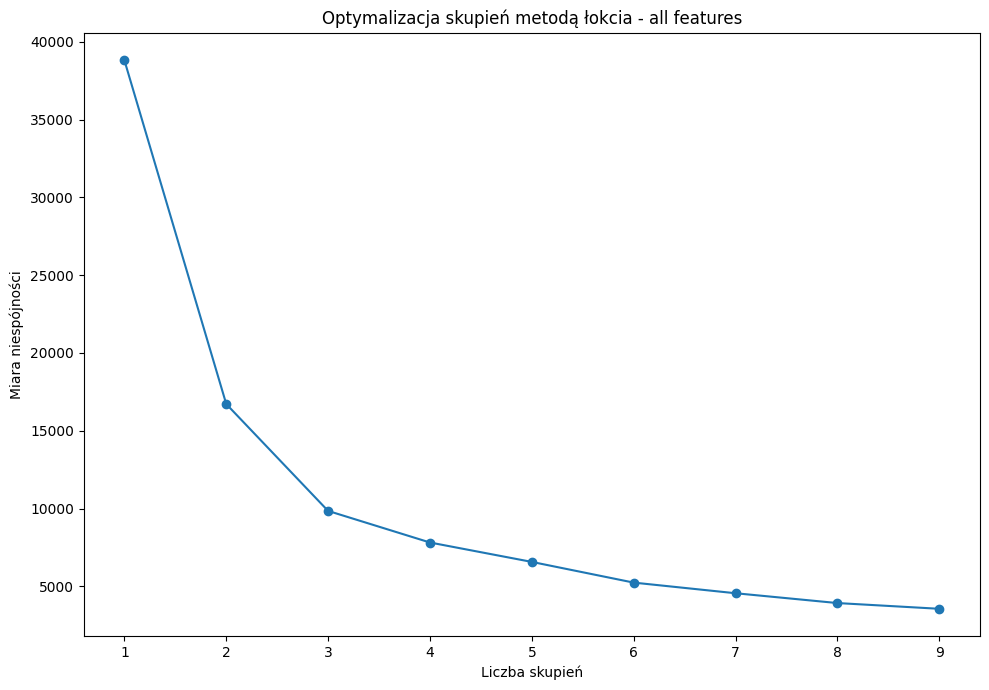

In [14]:
results = []
n = 10 #Liczba eksperymentów
for k in range(1, n):
        
    #Utworzenie obiektu do grupowania    
    kmeans = KMeans(n_clusters=k,init='k-means++',n_init=10,max_iter=300,random_state=0)
    kmeans.fit(single_ad)
    
    #Obliczenie jakości grupowania
    #Miara niespójności skupień: suma kwadratów odległości obiektów do środka najbliższego skupienia
    inertia = kmeans.inertia_ #Powinna być jak najmniejsza
    
    results.append(inertia)
    
    print("*** Eksperyment numer: " + str(k) + " Jakość = ", inertia)

#Na podstawie poniższego wykresu wybieramy takie k, które jest bliskie punktu przegięcia 

fig = plt.figure(figsize=(10, 7))
plt.plot(range(1,n), results , marker='o')
plt.title("Optymalizacja skupień metodą łokcia - all features")
plt.xlabel('Liczba skupień')
plt.ylabel('Miara niespójności')
plt.tight_layout()
plt.show()

# Miara Silhouette

In [21]:
from sklearn.metrics import silhouette_score
clusters = kmeans.fit_predict(single_ad)
silhouette_avg = silhouette_score(single_ad, clusters)
print(f"Średnia wartość silhouette dla wszystkich cech, liczba skupień 2: {silhouette_avg:.3f}")

silhouette_avg3 = silhouette_score(single_ad, clusters3)
print(f"Średnia wartość silhouette dla wszystkich cech, liczba skupień 3: {silhouette_avg3:.3f}")

Średnia wartość silhouette dla wszystkich cech, liczba skupień 2: 0.325
Średnia wartość silhouette dla wszystkich cech, liczba skupień 3: 0.429


*** Eksperyment numer: 2 Jakość =  0.46905923911239444
*** Eksperyment numer: 3 Jakość =  0.42940662042372574
*** Eksperyment numer: 4 Jakość =  0.4410454034531885
*** Eksperyment numer: 5 Jakość =  0.3525597048627713
*** Eksperyment numer: 6 Jakość =  0.3481894726744189
*** Eksperyment numer: 7 Jakość =  0.36491967778344514
*** Eksperyment numer: 8 Jakość =  0.3255797738688559
*** Eksperyment numer: 9 Jakość =  0.3248170535656793


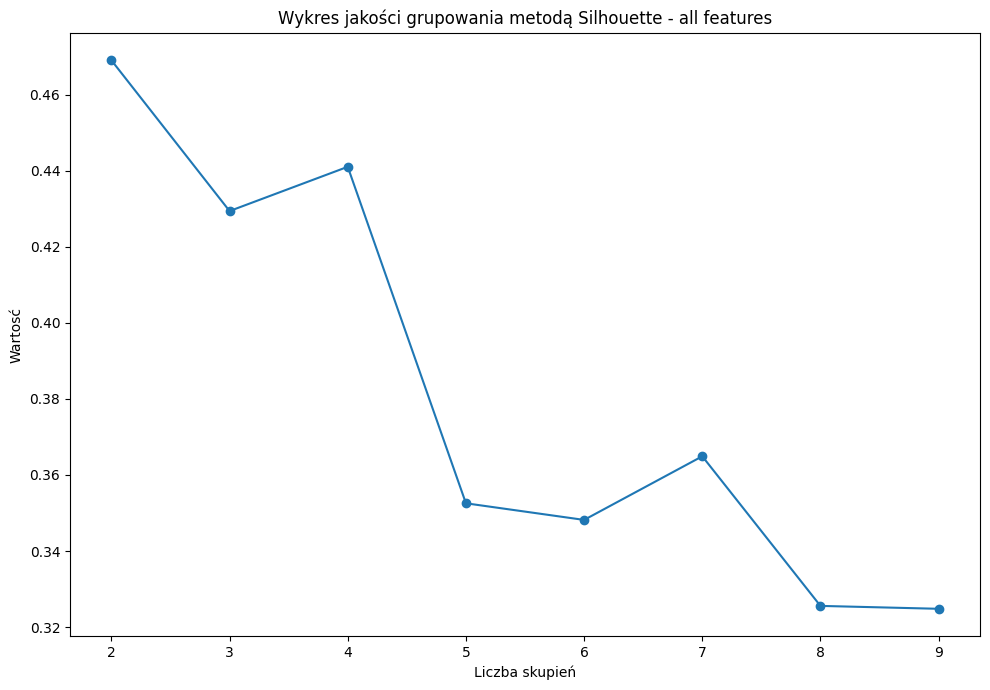

In [16]:
results = []
for k in range(2, 10):
        
    #Utworzenie obiektu do grupowania    
    kmeans = KMeans(n_clusters=k,init='k-means++',n_init=10,max_iter=300,random_state=0)

    kmeans.fit(single_ad)
    clusters = kmeans.predict(single_ad)
    #Obliczenie jakości grupowania
    silhouette_avg = silhouette_score(single_ad, clusters) #Powinna być jak najbliższa 1, ale broń Boże nie poniżej 0
    results.append(silhouette_avg)
    
    print("*** Eksperyment numer: " + str(k) + " Jakość = ", silhouette_avg)

fig = plt.figure(figsize=(10, 7))
plt.plot(range(2,n), results , marker='o')
plt.title("Wykres jakości grupowania metodą Silhouette - all features")
plt.xlabel('Liczba skupień')
plt.ylabel('Wartosć')
plt.tight_layout()
plt.show()

# Indeks Davies - Bouldin

In [17]:
# Obliczenie indeksu Davies-Bouldin
from sklearn.metrics import davies_bouldin_score
clusters = kmeans.fit_predict(single_ad)

dbi = davies_bouldin_score(single_ad, clusters)
print(f"Indeks Davies-Bouldin, liczba skupień 2: {dbi:.3f}")

dbi3 = davies_bouldin_score(single_ad, clusters3)
print(f"Indeks Davies-Bouldin, liczba skupień 3: {dbi3:.3f}")

Indeks Davies-Bouldin, liczba skupień 2: 1.007
Indeks Davies-Bouldin, liczba skupień 3: 0.799


*** Eksperyment numer: 2 Jakość =  0.7335813425102187
*** Eksperyment numer: 3 Jakość =  0.798763543168982
*** Eksperyment numer: 4 Jakość =  0.686530277010052
*** Eksperyment numer: 5 Jakość =  0.8209799555184756
*** Eksperyment numer: 6 Jakość =  0.8879745697981439
*** Eksperyment numer: 7 Jakość =  0.8134403781763504
*** Eksperyment numer: 8 Jakość =  0.9659800873716886
*** Eksperyment numer: 9 Jakość =  1.0070343012126333


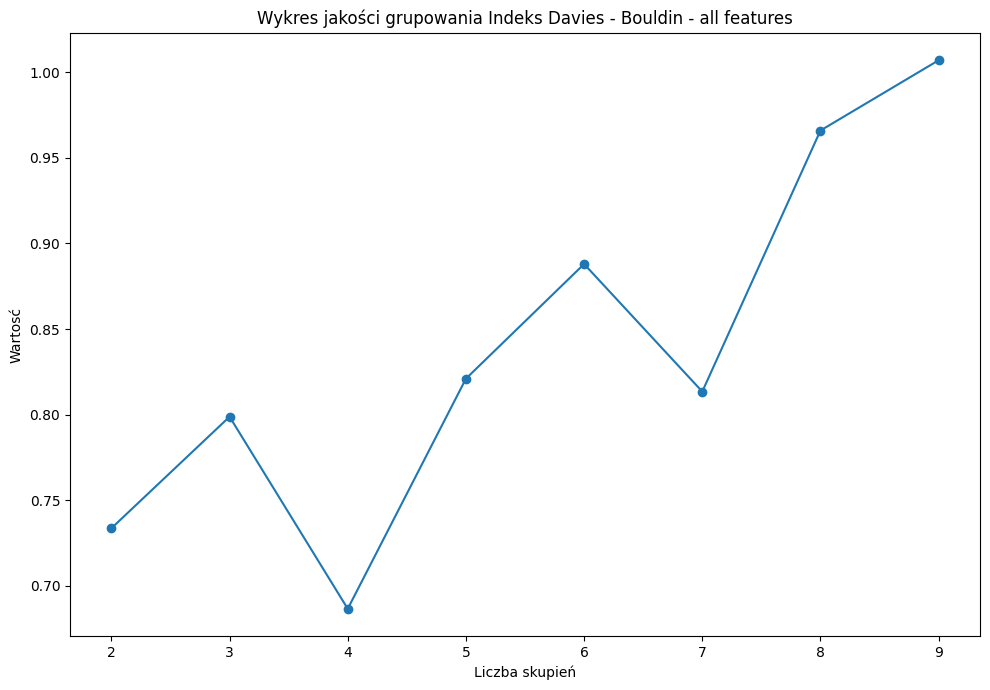

In [18]:
results = []
for k in range(2, 10):
        
    #Utworzenie obiektu do grupowania    
    kmeans = KMeans(n_clusters=k,init='k-means++',n_init=10,max_iter=300,random_state=0)

    kmeans.fit(single_ad)
    clusters = kmeans.predict(single_ad)
    #Obliczenie jakości grupowania
    dbi = davies_bouldin_score(single_ad, clusters)
    results.append(dbi)
    
    print("*** Eksperyment numer: " + str(k) + " Jakość = ", dbi)

fig = plt.figure(figsize=(10, 7))
plt.plot(range(2,n), results , marker='o')
plt.title("Wykres jakości grupowania Indeks Davies - Bouldin - all features")
plt.xlabel('Liczba skupień')
plt.ylabel('Wartosć')
plt.tight_layout()
plt.show()

# Miara Calinski-Harabasz

In [19]:
from sklearn.metrics import calinski_harabasz_score
clusters = kmeans.fit_predict(single_ad)
ch_score = calinski_harabasz_score(single_ad, clusters)
print("Calinski-Harabasz score, liczba skupień 2:", ch_score)

ch_score3 = calinski_harabasz_score(single_ad, clusters3)
print("Calinski-Harabasz score, liczba skupień 3:", ch_score3)

Calinski-Harabasz score, liczba skupień 2: 104.14160550166643
Calinski-Harabasz score, liczba skupień 3: 132.38805644004776


*** Eksperyment numer: 2 Jakość =  120.30420856729724
*** Eksperyment numer: 3 Jakość =  132.38805644004776
*** Eksperyment numer: 4 Jakość =  117.65747463529014
*** Eksperyment numer: 5 Jakość =  107.99651163679904
*** Eksperyment numer: 6 Jakość =  111.52316381443748
*** Eksperyment numer: 7 Jakość =  107.80103505413796
*** Eksperyment numer: 8 Jakość =  107.9693335122067
*** Eksperyment numer: 9 Jakość =  104.14160550166643


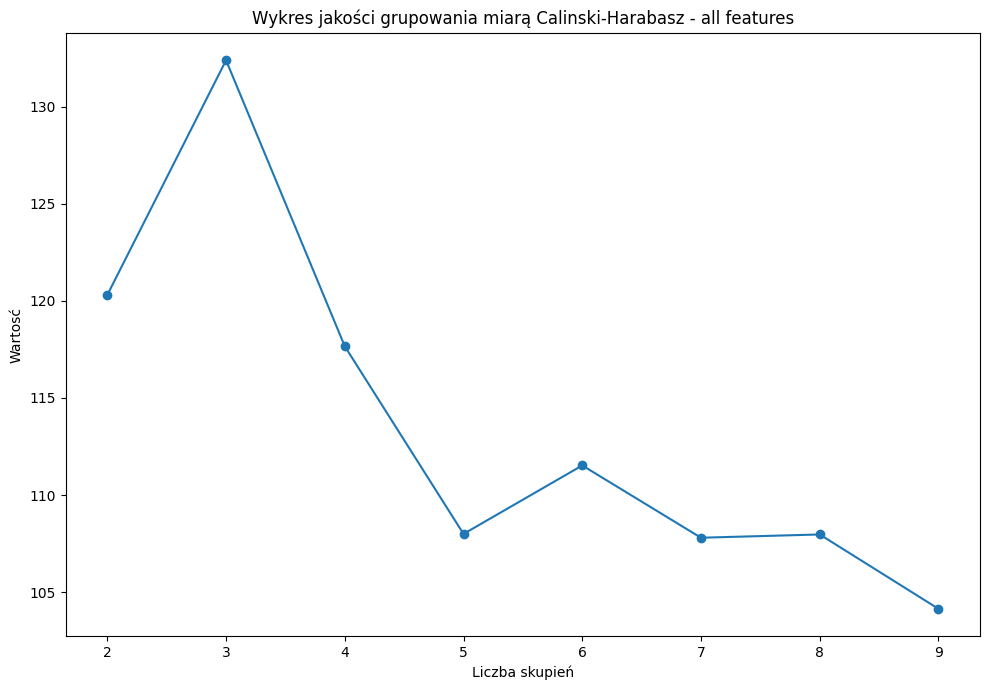

In [20]:
results = []
for k in range(2, 10):
        
    #Utworzenie obiektu do grupowania    
    kmeans = KMeans(n_clusters=k,init='k-means++',n_init=10,max_iter=300,random_state=0)

    kmeans.fit(single_ad)
    clusters = kmeans.predict(single_ad)
    #Obliczenie jakości grupowania
    ch_score = calinski_harabasz_score(single_ad, clusters)
    results.append(ch_score)
    
    print("*** Eksperyment numer: " + str(k) + " Jakość = ", ch_score)

fig = plt.figure(figsize=(10, 7))
plt.plot(range(2,n), results , marker='o')
plt.title("Wykres jakości grupowania miarą Calinski-Harabasz - all features")
plt.xlabel('Liczba skupień')
plt.ylabel('Wartosć')
plt.tight_layout()
plt.show()

# Wizualizacja skupień 
Metoda PCA

C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


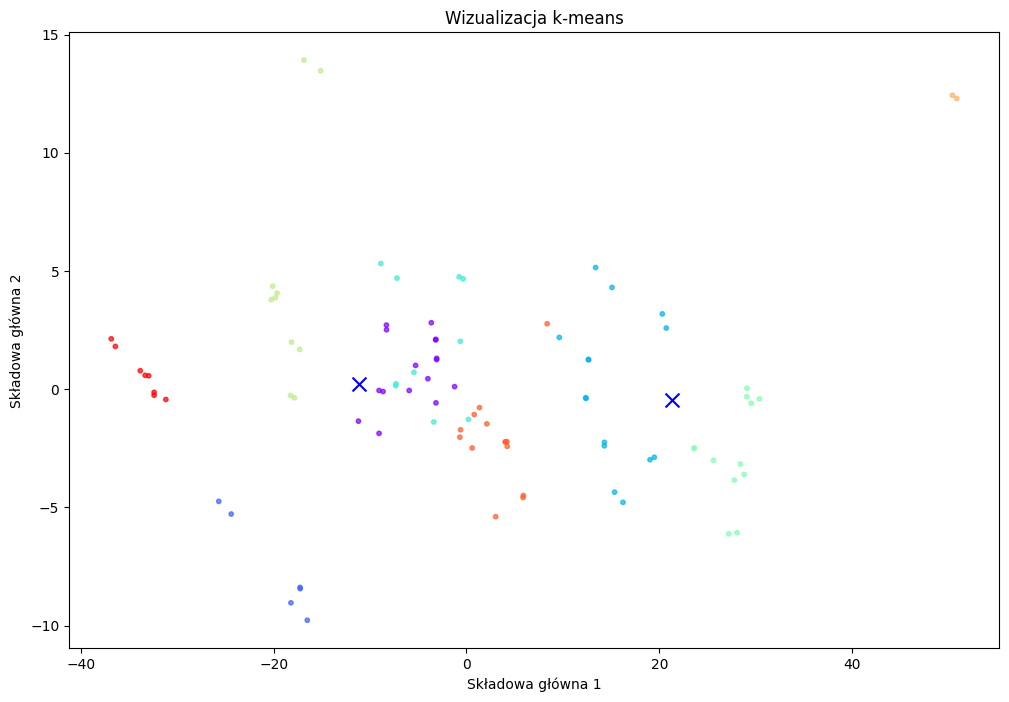

In [112]:
clusters = kmeans.fit_predict(single_ad)

#Redukcja wymiarów za pomocą PCA - dane są sprowadzane do 2 wymiarów
pca = PCA(n_components=2)
features_pca = pca.fit_transform(single_ad)
centroids_pca = pca.transform(centroids)

plt.figure(figsize=(12, 8))
plt.title('Wizualizacja k-means')
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=clusters, cmap='rainbow', s=10, alpha=0.7)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], s=100, color='blue', marker='x')
plt.xlabel('Składowa główna 1')
plt.ylabel('Składowa główna 2')
plt.show()

# Grupowanie metodą hierarchiczną

In [113]:
ac = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='complete')
ac.fit(single_ad)

print(len(single_ad))

clustersHierarchy = ac.fit_predict(single_ad)

for i in range(0,len(clusters)):
    print("Obiekt numer:"+str(i)," Skupienie:"+str(clustersHierarchy[i]))

93
Obiekt numer:0  Skupienie:0
Obiekt numer:1  Skupienie:0
Obiekt numer:2  Skupienie:1
Obiekt numer:3  Skupienie:1
Obiekt numer:4  Skupienie:1
Obiekt numer:5  Skupienie:1
Obiekt numer:6  Skupienie:0
Obiekt numer:7  Skupienie:0
Obiekt numer:8  Skupienie:0
Obiekt numer:9  Skupienie:0
Obiekt numer:10  Skupienie:0
Obiekt numer:11  Skupienie:0
Obiekt numer:12  Skupienie:0
Obiekt numer:13  Skupienie:0
Obiekt numer:14  Skupienie:1
Obiekt numer:15  Skupienie:0
Obiekt numer:16  Skupienie:0
Obiekt numer:17  Skupienie:0
Obiekt numer:18  Skupienie:0
Obiekt numer:19  Skupienie:0
Obiekt numer:20  Skupienie:0
Obiekt numer:21  Skupienie:0
Obiekt numer:22  Skupienie:0
Obiekt numer:23  Skupienie:0
Obiekt numer:24  Skupienie:1
Obiekt numer:25  Skupienie:1
Obiekt numer:26  Skupienie:0
Obiekt numer:27  Skupienie:0
Obiekt numer:28  Skupienie:1
Obiekt numer:29  Skupienie:1
Obiekt numer:30  Skupienie:1
Obiekt numer:31  Skupienie:0
Obiekt numer:32  Skupienie:0
Obiekt numer:33  Skupienie:0
Obiekt numer:34  Skup

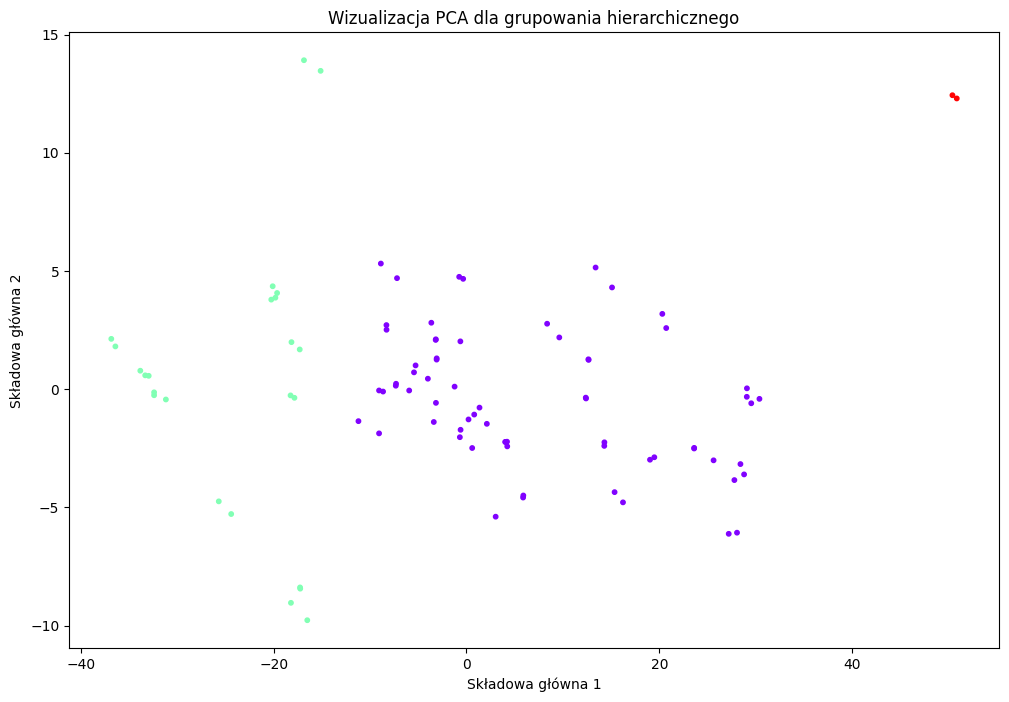

In [114]:
#Anxiety
# Redukcja wymiarów za pomocą PCA
pca = PCA(n_components=2)
features_pca = pca.fit_transform(single_ad)

plt.figure(figsize=(12, 8))
plt.title('Wizualizacja PCA dla grupowania hierarchicznego')
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=clustersHierarchy, s=10, alpha=0.99, cmap='rainbow')
plt.xlabel("Składowa główna 1")
plt.ylabel("Składowa główna 2")
plt.show()

# Właściwe grupowanie 

In [120]:
kmeans = KMeans(n_clusters=2, #Liczba skupień
                init='k-means++',
                n_init=10,
                max_iter=300, #Maksymalna liczba iteracji algorytmu
                random_state=0, #Ustawienie ziarna generatora liczb pseudo-losowych                
               )

kmeans.fit(single_ad) #Grupowanie

inertia = kmeans.inertia_
print("Miara jakości = ", inertia);

centroids = kmeans.cluster_centers_
print("Centroidy: \n", centroids)

clusters = kmeans.fit_predict(single_ad)

Miara jakości =  16713.707479508197
Centroidy: 
 [[ 1.81967213  1.14754098  1.37704918  1.3442623   1.06557377  1.01639344
   0.3442623   1.32786885  1.19672131  1.13114754  0.7704918   0.7704918
   0.73770492  1.55737705  1.13114754  0.72131148  0.98360656  0.73770492
   1.08196721  1.06557377  2.1147541   0.78688525  0.49180328  1.06557377
   1.04918033  7.47540984  9.40983607 41.13114754 13.42622951 15.72131148]
 [ 1.6875      1.15625     1.5         1.1875      0.96875     1.03125
   0.46875     1.25        1.1875      1.125       0.65625     0.90625
   0.78125     1.4375      1.0625      0.84375     1.125       0.71875
   0.96875     0.78125     3.4375      0.6875      0.5         1.5625
   1.875      17.9375     23.9375     54.4375     29.75       32.625     ]]


# Przypisanie grup do danych

In [121]:
# Przypisanie grup do danych - all_features
allGroups = single_ad.copy()
new_column = pd.Series(clusters, name='group')
allGroups = pd.concat([allGroups, new_column], axis=1)

#print(allGroups.head(10))

#Zestawienie wszystkich grup z wszystkimi
wiersze = []

for i in range(0,len(allGroups)-1):
    for j in range(0,len(allGroups)-1):
        if i != j:
            index_i = pd.Series(allGroups.index[i], index=['index_i'])
            features_i = allGroups.iloc[i,0:20].reset_index(drop=True)
            features_i.index = [f'feature_{k}_i' for k in range(0,len(features_i))]
            group_i = pd.Series(allGroups.iloc[i,30], index=['group_i'])
            index_j = pd.Series(allGroups.index[j], index=['index_j'])
            features_j = allGroups.iloc[j,0:20].reset_index(drop=True)
            features_j.index = [f'feature_{k}_j' for k in range(0,len(features_j))]
            group_j = pd.Series(allGroups.iloc[j,30], index=['group_j'])
            wiersz = pd.concat([features_i, features_j, index_i , group_i, index_j, group_j], axis=0)
            wiersze.append(wiersz)

allFeaturesZestawienie = pd.DataFrame(wiersze)
print(allFeaturesZestawienie.tail())

     feature_0_i feature_1_i feature_2_i feature_3_i feature_4_i feature_5_i  \
8367           2           2           2           2           1           1   
8368           2           2           2           2           1           1   
8369           2           2           2           2           1           1   
8370           2           2           2           2           1           1   
8371           2           2           2           2           1           1   

     feature_6_i feature_7_i feature_8_i feature_9_i  ... feature_14_j  \
8367           1           1           0           1  ...            1   
8368           1           1           0           1  ...            0   
8369           1           1           0           1  ...            1   
8370           1           1           0           1  ...            2   
8371           1           1           0           1  ...            2   

     feature_15_j feature_16_j feature_17_j feature_18_j feature_19_j inde

# Reguły decyzyjne

In [122]:
# Reguły decyzyjne
allFeaturesRules = allFeaturesZestawienie.copy()

#Zestawienie wszystkich grup z wszystkimi
rows = []

for i in range(0,len(allFeaturesRules)):
    row = allFeaturesRules.iloc[i]
    if int(row['group_i']) != int(row['group_j']): #wykluczenie wierszy, w których nie ma zmiany grupy
        wiersz = {
            'feature_0_a': f"\"{row['feature_0_i']}-{row['feature_0_j']}\"",
            'feature_1_a': f"\"{row['feature_1_i']}-{row['feature_1_j']}\"",
            'feature_2_a': f"\"{row['feature_2_i']}-{row['feature_2_j']}\"",
            'feature_3_a': f"\"{row['feature_3_i']}-{row['feature_3_j']}\"",
            'feature_4_a': f"\"{row['feature_4_i']}-{row['feature_4_j']}\"",
            'feature_5_a': f"\"{row['feature_5_i']}-{row['feature_5_j']}\"",
            'feature_6_a': f"\"{row['feature_6_i']}-{row['feature_6_j']}\"",
            'feature_7_a': f"\"{row['feature_7_i']}-{row['feature_7_j']}\"",
            'feature_8_a': f"\"{row['feature_8_i']}-{row['feature_8_j']}\"",
            'feature_9_a': f"\"{row['feature_9_i']}-{row['feature_9_j']}\"",
            'feature_0_d': f"\"{row['feature_10_i']}-{row['feature_10_j']}\"",
            'feature_1_d': f"\"{row['feature_11_i']}-{row['feature_11_j']}\"",
            'feature_2_d': f"\"{row['feature_12_i']}-{row['feature_12_j']}\"",
            'feature_3_d': f"\"{row['feature_13_i']}-{row['feature_13_j']}\"",
            'feature_4_d': f"\"{row['feature_14_i']}-{row['feature_14_j']}\"",
            'feature_5_d': f"\"{row['feature_15_i']}-{row['feature_15_j']}\"",
            'feature_6_d': f"\"{row['feature_16_i']}-{row['feature_16_j']}\"",
            'feature_7_d': f"\"{row['feature_17_i']}-{row['feature_17_j']}\"",
            'feature_8_d': f"\"{row['feature_18_i']}-{row['feature_18_j']}\"",
            'feature_9_d': f"\"{row['feature_19_i']}-{row['feature_19_j']}\"",
            'group': f"\"{row['group_i']}-{row['group_j']}\""
        }
        rows.append(wiersz)

allFeaturesRules = pd.DataFrame(rows)
print(allFeaturesRules)

     feature_0_a feature_1_a feature_2_a feature_3_a feature_4_a feature_5_a  \
0          "3-2"       "3-2"       "2-1"       "3-1"       "3-1"       "2-1"   
1          "3-1"       "3-0"       "2-1"       "3-0"       "3-0"       "2-1"   
2          "3-2"       "3-2"       "2-2"       "3-1"       "3-2"       "2-1"   
3          "3-3"       "3-3"       "2-3"       "3-2"       "3-3"       "2-3"   
4          "3-1"       "3-1"       "2-1"       "3-1"       "3-1"       "2-1"   
...          ...         ...         ...         ...         ...         ...   
3835       "2-2"       "2-2"       "2-2"       "2-1"       "1-2"       "1-1"   
3836       "2-2"       "2-2"       "2-3"       "2-2"       "1-2"       "1-2"   
3837       "2-1"       "2-0"       "2-0"       "2-0"       "1-1"       "1-0"   
3838       "2-1"       "2-1"       "2-1"       "2-0"       "1-0"       "1-1"   
3839       "2-1"       "2-0"       "2-1"       "2-0"       "1-1"       "1-0"   

     feature_6_a feature_7_a feature_8_

# Eksport do formatu RSES

In [123]:
# Funkcja do eksportu DataFrame do formatu RSES
def export_to_tab(df, attributes_info, table_name, filename):
    """
    Eksportuje DataFrame do pliku w formacie tabelarycznym (tab).
    
    :param df: Pandas DataFrame z danymi.
    :param attributes_info: Lista krotek (nazwa_atrybutu, typ, [precision]).
    :param table_name: Nazwa tabeli.
    :param filename: Nazwa pliku wyjściowego.
    """
    with open(filename, 'w') as f:
        # Nagłówek
        f.write(f'TABLE "{table_name}"\n')
        f.write(f'ATTRIBUTES {len(attributes_info)}\n')
        for attr in attributes_info:
            line = f' {attr[0]} {attr[1]}'
            if len(attr) > 2:  # Jeśli podano precyzję
                line += f' {attr[2]}'
            f.write(line + '\n')
        f.write(f'OBJECTS {len(df)}\n')
        
        # Dane obiektów
        for _, row in df.iterrows():
            f.write(" ".join(map(str, row.values)) + '\n')

    print(f"Eksport zakończony. Plik został zapisany jako {filename}.")

In [124]:
attributes_info = [
    ("f_0_a","symbolic"),
    ("f_1_a","symbolic"),
    ("f_2_a","symbolic"),
    ("f_3_a","symbolic"),
    ("f_4_a","symbolic"),
    ("f_5_a","symbolic"),
    ("f_6_a","symbolic"),
    ("f_7_a","symbolic"),
    ("f_8_a","symbolic"),
    ("f_9_a","symbolic"),
    ("f_0_d","symbolic"),
    ("f_1_d","symbolic"),
    ("f_2_d","symbolic"),
    ("f_3_d","symbolic"),
    ("f_4_d","symbolic"),
    ("f_5_d","symbolic"),
    ("f_6_d","symbolic"),
    ("f_7_d","symbolic"),
    ("f_8_d","symbolic"),
    ("f_9_d","symbolic"),
    ("group","symbolic"),
]

# Eksport danych do pliku tab
export_to_tab(allFeaturesRules, attributes_info, table_name="all_features_plus_single_user", filename="all_features_plus_single_user_2_rules.tab")

Eksport zakończony. Plik został zapisany jako all_features_plus_single_user_2_rules.tab.
